* Sử dụng tập dữ liệu bank.csv chứa thông tin liên quan đến các chiến dịch tiếp thị trực tiếp - the direct marketing campaigns (dựa trên các cuộc gọi điện thoại) của một tổ chức ngân hàng Bồ Đào Nha. Thông thường, cần có nhiều contact cho cùng một khách hàng, để truy cập xem liệu có sản phẩm (tiền gửi ngân hàng có kỳ hạn - bank term deposit) sẽ được đăng ký (yes) hay không (no). Tập dữ liệu chứa một số thông tin khách hàng (như age, job...) và thông tin liên quan đến chiến dịch (chẳng hạn như contact hoặc communication type, day, month và duration của contact...).
* Đối với chiến dịch tiếp thị tiếp theo, công ty muốn sử dụng dữ liệu này và chỉ liên hệ với những khách hàng tiềm năng sẽ đăng ký tiền gửi có kỳ hạn, do đó giảm bớt nỗ lực cần thiết để liên hệ với những khách hàng không quan tâm. Để làm được điều này, cần tạo một mô hình có thể dự đoán liệu khách hàng có đăng ký tiền gửi có kỳ hạn hay không (y).

### Yêu cầu:
* Đọc dữ liệu, tìm hiểu sơ bộ về dữ liệu. Chuẩn hóa dữ liệu nếu cần
* Tạo X_train, X_test, y_train, y_test từ dữ liệu chuẩn hóa với tỷ lệ dữ liệu test là 0.3
* Áp dụng Random Forest, Tìm kết quả.
* Kiểm tra độ chính xác
* Đánh giá mô hình.
* Ghi mô hình nếu mô hình phù hợp

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc


In [2]:
# Đọc dữ liệu. Tìm hiểu sơ bộ về dữ liệu
bank = pd.read_csv('../../Data/bank.csv', sep = ';')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
bank['y']=bank['y'].replace({'no': 0, 'yes': 1})

In [4]:
bank['month'].replace(['jan', 'feb', 'mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],
                      [1,2,3,4,5,6,7,8,9,10,11,12], inplace = True)

In [5]:
bank.shape

(4521, 17)

In [6]:
# Kiểm tra dữ liệu null
print(bank.isnull().sum())
# => Không có dữ liệu null

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [7]:
bank.describe()

,age,balance,day,month,duration,campaign,pdays,previous,y
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,6.166777,263.961292,2.793630,39.766645,0.542579,0.115240
std,10.576211,3009.638142,8.247667,2.378380,259.856633,3.109807,100.121124,1.693562,0.319347
min,19.000000,-3313.000000,1.000000,1.000000,4.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,69.000000,9.000000,5.000000,104.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,444.000000,16.000000,6.000000,185.000000,2.000000,-1.000000,0.000000,0.000000
75%,49.000000,1480.000000,21.000000,8.000000,329.000000,3.000000,-1.000000,0.000000,0.000000
max,87.000000,71188.000000,31.000000,12.000000,3025.000000,50.000000,871.000000,25.000000,1.000000


In [8]:
bank.describe(include=['O'])

,job,marital,education,default,housing,loan,contact,poutcome
count,4521,4521,4521,4521,4521,4521,4521,4521
unique,12,3,4,2,2,2,3,4
top,management,married,secondary,no,yes,no,cellular,unknown
freq,969,2797,2306,4445,2559,3830,2896,3705


In [9]:
bank['y'].value_counts(0)

0    4000
1     521
Name: y, dtype: int64

In [10]:
X = bank.drop(['y'], axis=1)

In [11]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,10,79,1,-1,0,unknown
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,5,220,1,339,4,failure
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,4,185,1,330,1,failure
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,6,199,4,-1,0,unknown
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,5,226,1,-1,0,unknown


In [12]:
y = bank['y']

In [13]:
ohe = OneHotEncoder()
ohe = ohe.fit(X[['job', 'marital', 'education','default', 'housing', 'loan','contact', 'poutcome']])
X_ohe = ohe.transform(X[['job', 'marital', 'education','default', 'housing', 'loan','contact', 'poutcome']])

In [14]:
X_ohe

<4521x32 sparse matrix of type '<class 'numpy.float64'>'
	with 36168 stored elements in Compressed Sparse Row format>

In [15]:
X_ohe_new = X_ohe.toarray()

In [16]:
ohe.get_feature_names(['job', 'marital', 'education','default', 'housing', 'loan','contact', 'poutcome'])

array(['job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype=object)

In [17]:
X_ohe_new[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1.]])

In [18]:
X_ohe_df = pd.DataFrame(X_ohe_new, columns=ohe.get_feature_names(['job', 'marital', 'education','default','housing', 'loan','contact', 'poutcome']))

In [19]:
X_ohe_df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [20]:
X_new = pd.concat([X[['age', 'balance', 'day','month','duration', 'campaign','pdays', 'previous']], X_ohe_df], axis=1)

In [21]:
X_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  4521 non-null   int64  
 1   balance              4521 non-null   int64  
 2   day                  4521 non-null   int64  
 3   month                4521 non-null   int64  
 4   duration             4521 non-null   int64  
 5   campaign             4521 non-null   int64  
 6   pdays                4521 non-null   int64  
 7   previous             4521 non-null   int64  
 8   job_admin.           4521 non-null   float64
 9   job_blue-collar      4521 non-null   float64
 10  job_entrepreneur     4521 non-null   float64
 11  job_housemaid        4521 non-null   float64
 12  job_management       4521 non-null   float64
 13  job_retired          4521 non-null   float64
 14  job_self-employed    4521 non-null   float64
 15  job_services         4521 non-null   f

In [22]:
# Build model
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

In [23]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier()

In [24]:
model.score(X_new, y)

0.969033399690334

In [25]:
model.score(X_train, y_train)

1.0

In [26]:
model.score(X_test, y_test)

0.8968312453942521

In [27]:
# Đánh giá model
y_pred = model.predict(X_test)

In [28]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1182   23]
 [ 117   35]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1205
           1       0.60      0.23      0.33       152

    accuracy                           0.90      1357
   macro avg       0.76      0.61      0.64      1357
weighted avg       0.88      0.90      0.88      1357



In [29]:
# Print ROC_AUC score using probabilities
probs = model.predict_proba(X_test)

In [30]:
scores = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

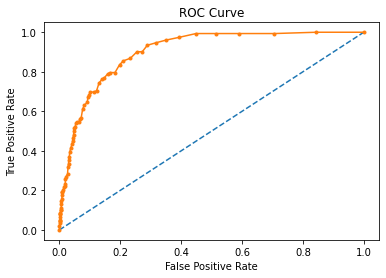

In [31]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [32]:
auc(fpr, tpr)

0.9031065734876611